<a href="https://colab.research.google.com/github/romauligraciella/Komputasi-Intelegensia/blob/main/TaskWeek6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama: Romauli Graciella Debora\
NPM: 2106722575

Original Code: https://www.kaggle.com/code/yossefmohammed/twitter-sentiment-analysis-with-gru \
Dataset: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/data

#**Sentiment Analysis with GRU**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Text cleaning
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Prepare data
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Modelling
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense,Input,GlobalMaxPooling1D,Dropout,Bidirectional
from tensorflow.keras.models import Model
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

In [ ]:
# Import Dataset
training = pd.read_csv("twitter_training.csv")
test = pd.read_csv("twitter_validation.csv")

In [ ]:
# Add headers in each dataframe
test.columns = ['ID', 'company','labels','text']
training.columns = ['ID', 'company','labels','text']

In [ ]:
# Delete unneeded columns
training.drop(columns=["ID","company"],inplace=True)
test.drop(columns=["ID","company"],inplace=True)

In [ ]:
training.head()

,labels,text
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...


In [ ]:
test.head()

,labels,text
0,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,Negative,@Microsoft Why do I pay for WORD when it funct...
2,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,Neutral,Now the President is slapping Americans in the...
4,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [ ]:
# Add two dataframe into one
sentiment = pd.concat([training,test],ignore_index=True)
sentiment

,labels,text
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...
...,...,...
75675,Irrelevant,⭐️ Toronto is the arts and culture capital of ...
75676,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
75677,Positive,Today sucked so it’s time to drink wine n play...
75678,Positive,Bought a fraction of Microsoft today. Small wins.


### Data Cleansing

In [ ]:
sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75680 entries, 0 to 75679
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   labels  75680 non-null  object
 1   text    74994 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [ ]:
sentiment.isnull().sum()

,0
labels,0
text,686


In [ ]:
sentiment.dropna(inplace=True)
sentiment.isnull().sum()

,0
labels,0
text,0


In [ ]:
sentiment.duplicated().sum()

4743

In [ ]:
sentiment.drop_duplicates(inplace=True)
sentiment.duplicated().sum()

0

### Data Preprocessing

In [ ]:
nltk.download('wordnet', "/kaggle/working/nltk_data/")
nltk.download('omw-1.4', "/kaggle/working/nltk_data/")
! unzip /kaggle/working/nltk_data/corpora/wordnet.zip -d /kaggle/working/nltk_data/corpora
! unzip /kaggle/working/nltk_data/corpora/omw-1.4.zip -d /kaggle/working/nltk_data/corpora
nltk.data.path.append("/kaggle/working/nltk_data/")

[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data/...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /kaggle/working/nltk_data/...


Archive:  /kaggle/working/nltk_data/corpora/wordnet.zip
   creating: /kaggle/working/nltk_data/corpora/wordnet/
  inflating: /kaggle/working/nltk_data/corpora/wordnet/lexnames  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/data.verb  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/index.adv  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/index.verb  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/data.adj  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/index.adj  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/README  
  inflating: /kaggle/w

In [ ]:
# Make function for cleaning the text
def process_text(text):
    text = re.sub(r'\s+', ' ', text, flags=re.I) # Remove extra white space from text

    text = re.sub(r'\W', ' ', str(text)) # Remove all the special characters from text

    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text) # Remove all single characters from text

    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove any character that isn't alphabetical

    text = text.lower()

    words = word_tokenize(text)

    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    stop_words = set(stopwords.words("english"))
    Words = [word for word in words if word not in stop_words]

    Words = [word for word in Words if len(word) > 3]

    indices = np.unique(Words, return_index=True)[1]
    cleaned_text = np.array(Words)[np.sort(indices)].tolist()

    return cleaned_text

In [ ]:
X = sentiment.drop('labels',axis=1)
y = sentiment.labels

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
texts = list(X['text'])
cleaned_text = [process_text(text) for text in texts]
print(cleaned_text[:10])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[['coming', 'border', 'kill'], ['getting', 'borderland', 'kill'], ['coming', 'borderland', 'murder'], ['getting', 'borderland', 'murder'], ['getting', 'borderland', 'murder'], ['spent', 'hour', 'making', 'something', 'know', 'huge', 'borderland', 'maya', 'favorite', 'character', 'decided', 'make', 'wallpaper', 'original', 'image', 'versus', 'creation', 'made', 'enjoy', 'twitter', 'mlsiwfjg'], ['spent', 'couple', 'hour', 'something', 'know', 'huge', 'borderland', 'maya', 'favorite', 'character', 'decided', 'make', 'wallpaper', 'original', 'picture', 'compared', 'creation', 'made', 'twitter', 'mlsiwfjg'], ['spent', 'hour', 'something', 'know', 'huge', 'borderland', 'maya', 'favorite', 'character'], ['spent', 'hour', 'making', 'something', 'know', 'huge', 'rhandlerr', 'maya', 'favorite', 'character', 'decided', 'make', 'wallpaper', 'original', 'image', 'versus', 'creation', 'made', 'enjoy', 'twitter', 'mlsiwfjg'], ['spent', 'hour', 'making', 'something', 'know', 'huge', 'rhandlerr', 'maya

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(cleaned_text, y, test_size=0.2, random_state=42)

In [ ]:
max_vocab = 40000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)
word_idx = tokenizer.word_index  # Corrected syntax for accessing word index
v = len(word_idx)
print("the size of vocab =", v)  # Corrected spacing
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

the size of vocab = 24048


In [ ]:
maxlen = 100
X_train = pad_sequences(X_train,maxlen=maxlen)
X_test = pad_sequences(X_test,maxlen=maxlen)

In [ ]:
y.value_counts()

,count
labels,
Negative,21329
Positive,19270
Neutral,17281
Irrelevant,12371


In [ ]:
D = 100
inputt = Input(shape=(maxlen,))

In [ ]:
learning_rate = 0.0001  # Set your desired learning rate here
x = Embedding(v+1,D)(inputt)
x = Dropout(0.5)(x)
x = Bidirectional(GRU(200))(x)
x = Dense(32, activation='relu')(x)
x = Dense(4, activation='softmax')(x)

model = Model(inputt, x)

# Define optimizer with specified learning rate
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded)
y_test_one_hot = tf.keras.utils.to_categorical(y_test_encoded)
history = model.fit(X_train, y_train_one_hot, epochs=40, validation_data=(X_test, y_test_one_hot))

Epoch 1/40
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.7325 - loss: 0.7005 - val_accuracy: 0.7687 - val_loss: 0.6251
Epoch 2/40
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.7919 - loss: 0.5566 - val_accuracy: 0.8003 - val_loss: 0.5334
Epoch 3/40
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - accuracy: 0.8285 - loss: 0.4576 - val_accuracy: 0.8186 - val_loss: 0.4847
Epoch 4/40
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - accuracy: 0.8503 - loss: 0.4003 - val_accuracy: 0.8363 - val_loss: 0.4428
Epoch 5/40
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.8632 - loss: 0.3682 - val_accuracy: 0.8431 - val_loss: 0.4220
Epoch 6/40
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.8773 - loss: 0.3258 - val_accuracy: 0.8535 - val_loss: 0.3992
Epoch 7/40
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.8874 - loss: 0.2969 - val_accuracy: 0.8581 - val_loss: 0.3884
Epoch 8/40
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.8941 -

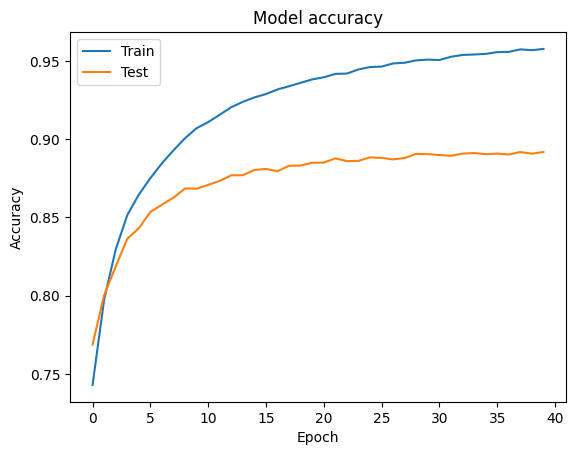

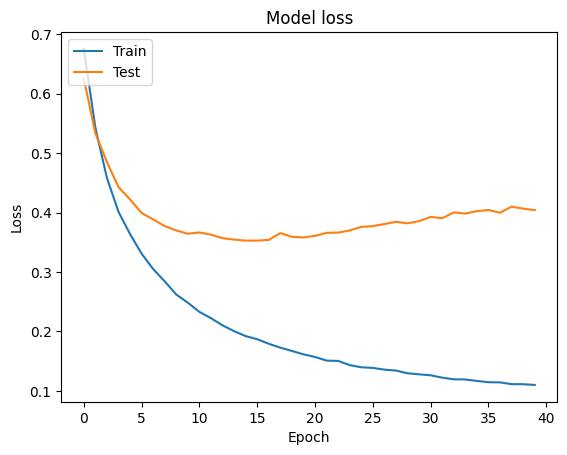

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test_one_hot)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8919 - loss: 0.3906
Test Loss: 0.40412330627441406
Test Accuracy: 0.8918226361274719


440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


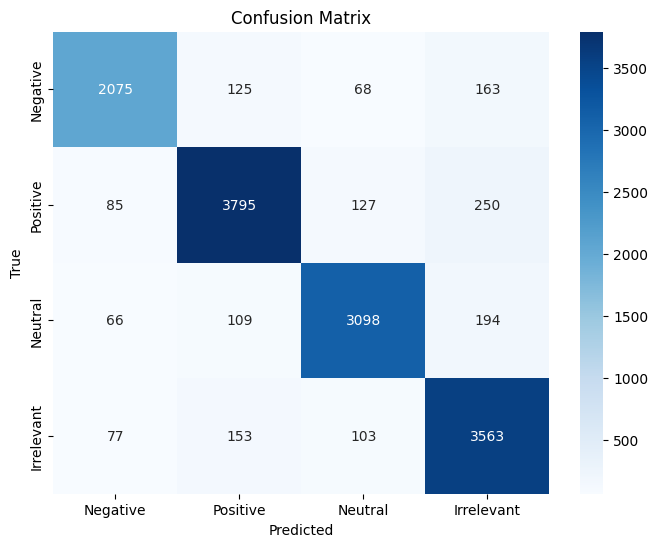

In [ ]:
y_pred_probs = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test_one_hot, axis=1)
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive', 'Neutral', 'Irrelevant'],
            yticklabels=['Negative', 'Positive', 'Neutral', 'Irrelevant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()